In [ ]:
# EXPENSE FORECASTING MODEL
# Predicts company expenses using XGBoost

# STEP 1: Upload file in Colab
from google.colab import files
uploaded = files.upload()

# STEP 2: Install dependencies
!pip install openpyxl xgboost scikit-learn --quiet

# STEP 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# STEP 4: Load Excel
file_path = list(uploaded.keys())[0]
df = pd.read_excel(file_path, engine="openpyxl")

print("📋 Dataset Overview:")
print(f"Total records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"\nAccount Base Types available: {df['Account Base Type'].unique()}")
print(f"Currency Codes available: {df['Currency Code'].unique()}")

# STEP 5: Filter for INR expenses (Fixed warnings)
# Create a copy to avoid SettingWithCopyWarning
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()

print(f"\n💰 Expense Data Overview:")
print(f"Total expense records: {len(expense_df):,}")

if len(expense_df) == 0:
    print("❌ No expense records found! Check your data for:")
    print("- Account Base Type values (should contain 'Expense')")
    print("- Currency Code values (should contain 'INR')")
    print("\nAvailable Account Base Types:")
    print(df['Account Base Type'].value_counts())
else:
    # Data preprocessing
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'])
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Debit - Credit'], inplace=True)

    # For expenses, we typically want absolute values (positive amounts)
    # Convert negative values to positive if needed
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    print(f"Date range: {expense_df['Transaction Date'].min()} to {expense_df['Transaction Date'].max()}")
    print(f"Total expense amount: ₹{expense_df['Expense Amount'].sum():,.2f}")
    print(f"Average daily expense: ₹{expense_df['Expense Amount'].mean():,.2f}")

# STEP 6: Daily aggregation with data quality checks
daily = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
daily.columns = ['ds', 'y']
daily = daily[daily['ds'] >= '2015-01-01'].copy()

# Remove extreme outliers (beyond 3 standard deviations)
# Only apply outlier removal if there's enough data and variability
if len(daily) > 1 and daily['y'].std() > 0:
    mean_val = daily['y'].mean()
    std_val = daily['y'].std()
    daily = daily[np.abs(daily['y'] - mean_val) <= 3 * std_val].copy()

print(f"\n📊 Daily Expense Summary:")
print(f"Total days with expenses: {len(daily):,}")
print(f"Average daily expense: ₹{daily['y'].mean():,.2f}")
print(f"Median daily expense: ₹{daily['y'].median():,.2f}")
print(f"Max daily expense: ₹{daily['y'].max():,.2f}")

# STEP 7: Enhanced Feature Engineering for Expenses
def create_expense_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding for seasonal expense patterns
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features (important for expense patterns)
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)  # Financial year end in India
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates (expense timing patterns)
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features (expense history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df[f'expense_lag_{lag}'] = df['y'].shift(lag)

    # Rolling statistics for expense trends
    for window in [7, 14, 30, 90]:
        df[f'expense_rolling_mean_{window}'] = df['y'].rolling(window, min_periods=1).mean().shift(1)
        df[f'expense_rolling_std_{window}'] = df['y'].rolling(window, min_periods=1).std().shift(1)
        df[f'expense_rolling_max_{window}'] = df['y'].rolling(window, min_periods=1).max().shift(1)
        df[f'expense_rolling_min_{window}'] = df['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df['historical_month_expense'] = df.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_quarter_expense'] = df.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_dow_expense'] = df.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Expense volatility features
    df['expense_volatility_7d'] = df['y'].rolling(7).std().shift(1)
    df['expense_volatility_30d'] = df['y'].rolling(30).std().shift(1)

    # Expense growth rates - Handle division by zero to avoid 'inf'
    df['expense_growth_7d'] = ((df['y'] / df['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df['expense_growth_30d'] = ((df['y'] / df['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    # Expense ratios and patterns - Handle division by zero to avoid 'inf'
    # Use a small epsilon to prevent division by zero in case rolling_max/min is 0
    epsilon = 1e-6
    df['expense_ratio_to_max'] = df['y'] / (df['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df['expense_ratio_to_min'] = df['y'] / (df['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df

# Apply feature engineering
daily_features = create_expense_features(daily)

# Critical: Replace inf values with NaN and then fill NaNs.
# `bfill` first, then `ffill` (forward fill) for any remaining NaNs, and finally `0` for any at the start.
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
daily_features.fillna(method='bfill', inplace=True) # Fill NaNs backward
daily_features.fillna(method='ffill', inplace=True) # Fill any remaining NaNs forward (important for initial NaNs)
daily_features.fillna(0, inplace=True) # Fill any remaining NaNs (e.g., if a column was all NaN)

# STEP 8: Split train/test
train = daily_features[daily_features['ds'] < '2025-01-01'].copy()
test = daily_features[(daily_features['ds'] >= '2025-01-01') &
                      (daily_features['ds'] <= '2025-05-31')].copy()

# Select features (excluding target and date columns)
feature_cols = [col for col in daily_features.columns if col not in ['ds', 'y']]

print(f"\n🎯 Model Training Setup:")
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")
print(f"Number of features: {len(feature_cols)}")

if len(test) == 0:
    print("❌ No test data available for 2025. Adjusting date range...")
    # Use last 6 months as test data if no 2025 data exists
    test_start_date = daily_features['ds'].max() - pd.DateOffset(months=6)
    train = daily_features[daily_features['ds'] < test_start_date].copy()
    test = daily_features[daily_features['ds'] >= test_start_date].copy()
    print(f"Adjusted - Training until: {test_start_date}")
    print(f"Testing from: {test_start_date} to {daily_features['ds'].max()}")

# STEP 9: Train expense forecasting model
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# Train the model
print("🚀 Training expense forecasting model...")
model.fit(train[feature_cols], train['y'])

# STEP 10: Make expense predictions
test_pred = test.copy()
test_pred['expense_forecast'] = model.predict(test[feature_cols])
test_pred['expense_forecast'] = test_pred['expense_forecast'].clip(lower=0) # Ensure predictions are non-negative

# STEP 11: Monthly aggregation for comparison
monthly_actual = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['y'].sum()
monthly_forecast = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['expense_forecast'].sum()

# STEP 12: Calculate expense forecast metrics
mae = mean_absolute_error(monthly_actual, monthly_forecast)
rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

# Handle division by zero in MAPE calculation
def safe_mape(actual, forecast):
    mask = actual != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

mape = safe_mape(monthly_actual.values, monthly_forecast.values)
accuracy = 100 - mape

# STEP 13: Create expense comparison table (Monthly)
comparison_df = pd.concat([monthly_actual, monthly_forecast], axis=1)
comparison_df.columns = ['Actual Expenses (INR)', 'Forecast Expenses (INR)']
comparison_df['Error'] = comparison_df['Actual Expenses (INR)'] - comparison_df['Forecast Expenses (INR)']
# Handle potential division by zero for 'Actual Expenses (INR)' when calculating Absolute % Error
comparison_df['Absolute % Error'] = (comparison_df['Error'].abs() /
                                     comparison_df['Actual Expenses (INR)'].replace(0, np.nan).abs()) * 100
comparison_df.index = comparison_df.index.to_timestamp()

print("\n💸 Monthly Expense Forecast Summary Table:")
print(comparison_df.round(2))

### Daily Expense Forecast Summary

# NEW STEP: Daily Expense Comparison Table
print("\n🗓️ Daily Expense Forecast Summary Table:")
daily_comparison_df = test_pred[['ds', 'y', 'expense_forecast']].copy()
daily_comparison_df.columns = ['Date', 'Actual Daily Expenses (INR)', 'Forecast Daily Expenses (INR)']
daily_comparison_df['Error'] = daily_comparison_df['Actual Daily Expenses (INR)'] - daily_comparison_df['Forecast Daily Expenses (INR)']
# Handle potential division by zero for 'Actual Daily Expenses (INR)' when calculating Absolute % Error
daily_comparison_df['Absolute % Error'] = (daily_comparison_df['Error'].abs() /
                                           daily_comparison_df['Actual Daily Expenses (INR)'].replace(0, np.nan).abs()) * 100
print(daily_comparison_df.round(2).to_markdown(index=False)) # Using .to_markdown() for proper table printing

Saving Predictive_Analysis_Final.xlsx to Predictive_Analysis_Final (1).xlsx
📋 Dataset Overview:
Total records: 416,877
Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

Account Base Types available: ['Asset' 'Expense' 'Income' 'Liability' 'Equity']
Currency Codes available: ['INR' 'USD' 'PHP' 'LKR' 'BHD' 'QAR' 'KWD' 'HKD' 'BDT' 'IDR' 'EGP' 'VND'
 'MYR' 'KRW' 'JPY' 'KHR' 'AED' 'SGD' 'MXN' 'JOD' 'OMR' 'KES' 'TZS' 'ZAR'
 'BGN' 'PLN' 'CNY' 'THB' 'NZD' 'EUR' 'AUD' 'GBP' 'CHF' 'SAR' 'MAD' 'UGX'
 'GEL' 'IRR' 'TWD' 'MMK' 'DOP' 'NPR' 'CAD' 'JMD' 'AZN' 'BRL' 'ETB' 'SEK'
 'NGN' 'HUF' 'TRY' 'XAF' 'AMD' 'XOF']

💰 Expense Data Overview:
Total expense records: 61,925
Date range: 2015-04-01 00:00:00 to 2025-05-31 00:00:00
Total expense amount: ₹5,218,915,014.77
Average daily expense: ₹84,278.00

📊 Daily Expense Summary:
Total days with expenses: 3,103
Average dail

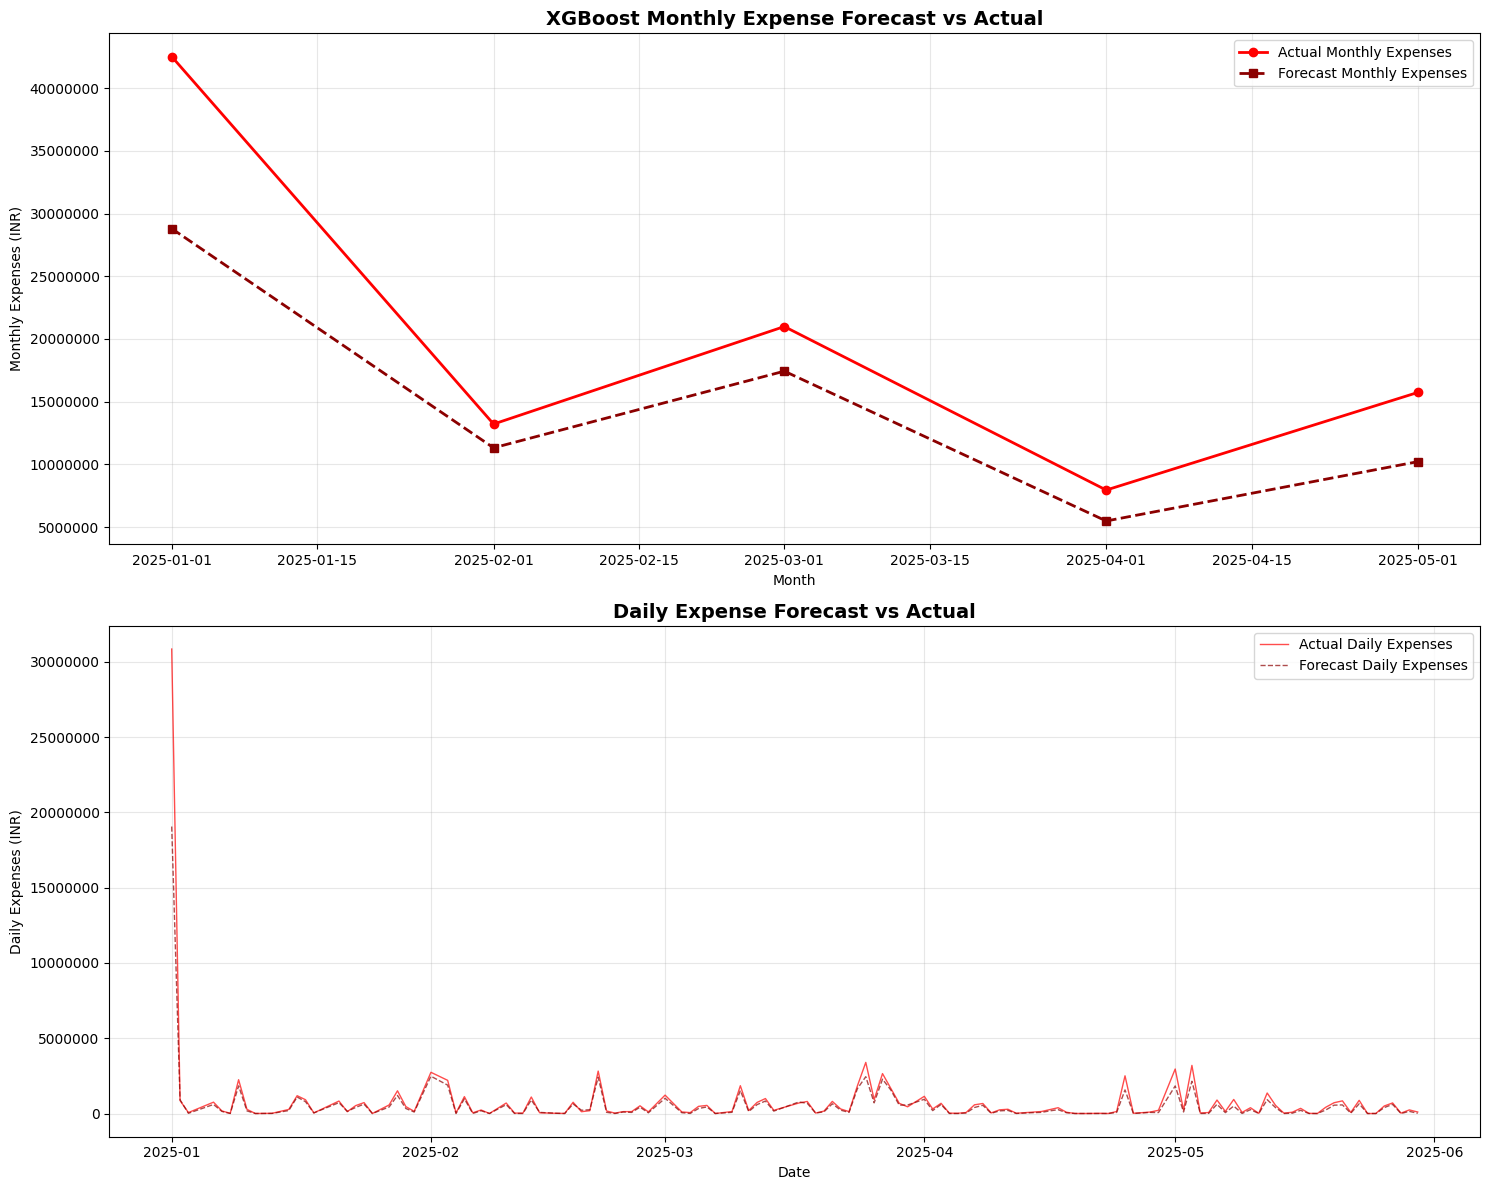


📈 Expense Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹5,428,727.12
RMSE (Root Mean Square Error): ₹6,939,180.14
MAPE (Mean Absolute Percentage Error): 25.91%
✅ Expense Forecast Accuracy: 74.09%

📊 Top 15 Most Important Features for Expense Prediction:
                     feature  importance
18         days_to_month_end      0.2253
51      expense_ratio_to_max      0.2048
11              is_month_end      0.1856
52      expense_ratio_to_min      0.0823
39   expense_rolling_mean_90      0.0696
43  historical_month_expense      0.0267
40    expense_rolling_std_90      0.0261
50          days_since_start      0.0233
41    expense_rolling_max_90      0.0220
49        expense_growth_30d      0.0177
2                       year      0.0126
8                    day_cos      0.0094
5                  month_sin      0.0090
34    expense_rolling_min_14      0.0087
30     expense_rolling_min_7      0.0074


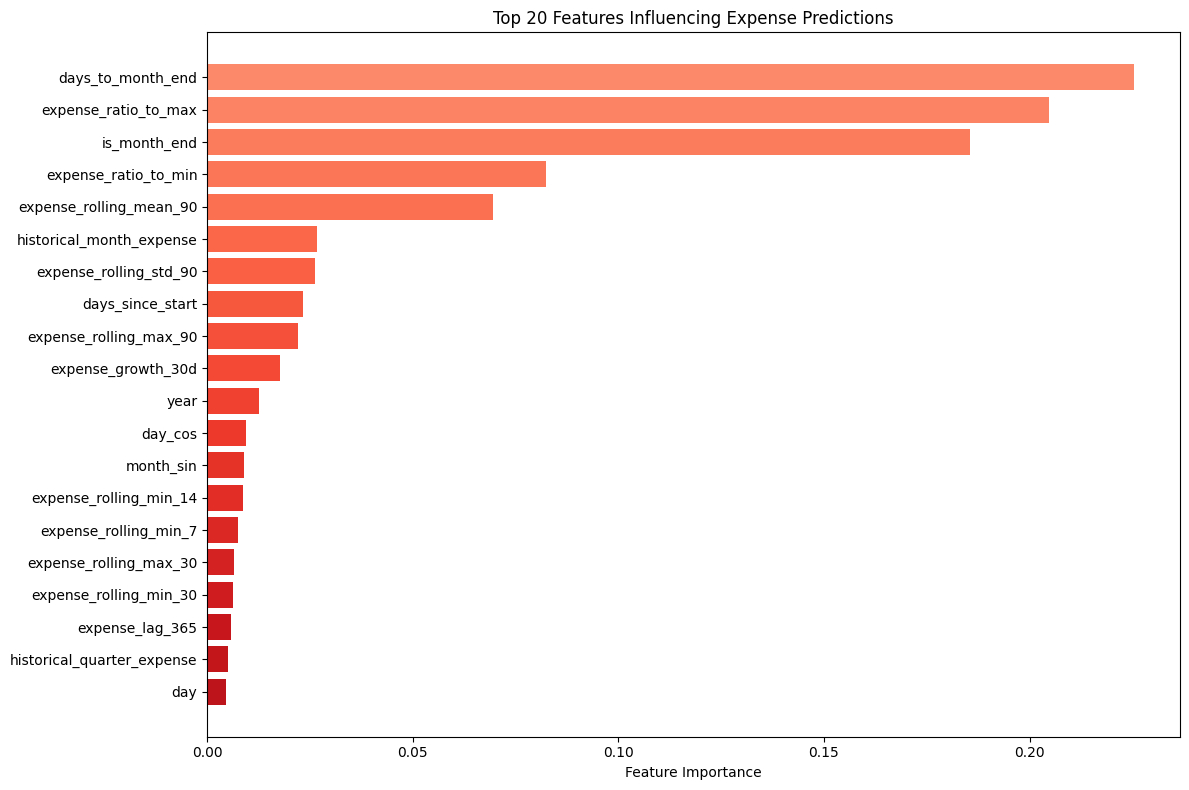

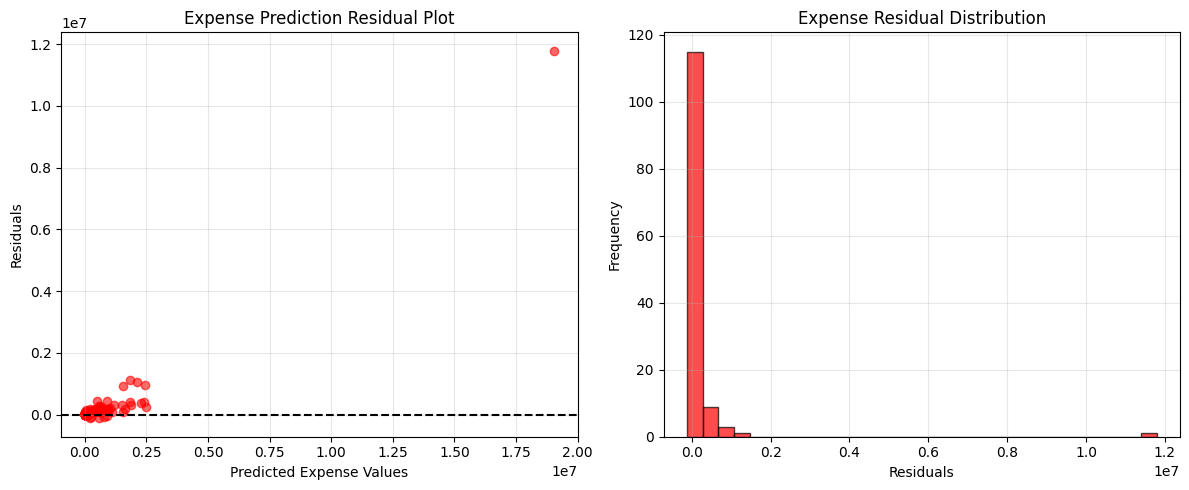


📊 Expense Residual Statistics:
Mean Residual: ₹210,415.79
Std Residual: ₹1,044,947.90
Min Residual: ₹-119,779.87
Max Residual: ₹11,787,425.51

💡 Expense Forecasting Insights:
Total Actual Expenses: ₹100,410,623.61
Total Forecast Expenses: ₹73,266,984.00
Total Difference: ₹27,143,639.61
✅ Good expense forecast accuracy!

🎯 Model is ready to predict future expenses!
Use this model for: Budget planning, Cash flow management, Cost control


In [ ]:
# STEP 14: Expense Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Monthly expense comparison
ax1.plot(comparison_df.index, comparison_df['Actual Expenses (INR)'],
         label='Actual Monthly Expenses', color='red', linewidth=2, marker='o')
ax1.plot(comparison_df.index, comparison_df['Forecast Expenses (INR)'],
         label='Forecast Monthly Expenses', color='darkred', linewidth=2,
         linestyle='--', marker='s')
ax1.set_title("XGBoost Monthly Expense Forecast vs Actual", fontsize=14, fontweight='bold')
ax1.set_xlabel("Month")
ax1.set_ylabel("Monthly Expenses (INR)")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='plain', axis='y')

# Daily expense comparison for detailed view
ax2.plot(test_pred['ds'], test_pred['y'], label='Actual Daily Expenses',
         color='red', alpha=0.7, linewidth=1)
ax2.plot(test_pred['ds'], test_pred['expense_forecast'], label='Forecast Daily Expenses',
         color='darkred', alpha=0.7, linewidth=1, linestyle='--')
ax2.set_title("Daily Expense Forecast vs Actual", fontsize=14, fontweight='bold')
ax2.set_xlabel("Date")
ax2.set_ylabel("Daily Expenses (INR)")
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# STEP 15: Expense forecast performance metrics
print(f"\n📈 Expense Forecast Performance Metrics:")
print(f"MAE (Mean Absolute Error): ₹{mae:,.2f}")
print(f"RMSE (Root Mean Square Error): ₹{rmse:,.2f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"✅ Expense Forecast Accuracy: {accuracy:.2f}%")

# STEP 16: Feature importance analysis for expenses
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 Top 15 Most Important Features for Expense Prediction:")
print(feature_importance.head(15).round(4))

# Plot expense feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(20)
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_features)))
plt.barh(range(len(top_features)), top_features['importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features Influencing Expense Predictions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# STEP 17: Expense residual analysis
residuals = test_pred['y'] - test_pred['expense_forecast']
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_pred['expense_forecast'], residuals, alpha=0.6, color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Predicted Expense Values')
plt.ylabel('Residuals')
plt.title('Expense Prediction Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='red')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Expense Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Expense Residual Statistics:")
print(f"Mean Residual: ₹{residuals.mean():,.2f}")
print(f"Std Residual: ₹{residuals.std():,.2f}")
print(f"Min Residual: ₹{residuals.min():,.2f}")
print(f"Max Residual: ₹{residuals.max():,.2f}")

# STEP 18: Summary insights
print(f"\n💡 Expense Forecasting Insights:")
total_actual = monthly_actual.sum()
total_forecast = monthly_forecast.sum()
print(f"Total Actual Expenses: ₹{total_actual:,.2f}")
print(f"Total Forecast Expenses: ₹{total_forecast:,.2f}")
print(f"Total Difference: ₹{abs(total_actual - total_forecast):,.2f}")

if accuracy > 70:
    print("✅ Good expense forecast accuracy!")
elif accuracy > 50:
    print("⚠️ Moderate expense forecast accuracy - consider more data or features")
else:
    print("❌ Low expense forecast accuracy - model needs improvement")

print(f"\n🎯 Model is ready to predict future expenses!")
print(f"Use this model for: Budget planning, Cash flow management, Cost control")

In [ ]:
pip install xgboost scikit-learn pandas numpy matplotlib

Original DataFrame shape after loading: (683302, 10)
Original DataFrame columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

💰 Expense Data Overview:
Total expense records: 75,955
Date range: 2018-12-31 00:00:00 to 2026-04-02 00:00:00
Total expense amount: ₹6,641,658,904.83
Average daily expense: ₹87,442.02
Shape after outlier removal: (1189, 2) (Removed 28 rows)

📊 Daily Expense Summary:
Total days with expenses: 1,189
Average daily expense: ₹3,960,269.82
Median daily expense: ₹80,793.41
Max daily expense: ₹44,383,133.75

🎯 Model Training Setup:
Daily Features shape: (1189, 55)
Test data will cover from 2025-03-01 to 2025-05-31
Training data shape: (1089, 55)
Test data shape: (86, 55)
Number of features: 53
🚀 Training expense forecasting model...

💸 Monthly Expense Forecast Summary Table:
            Actual Expenses (INR)  Forecast Expenses (INR)    

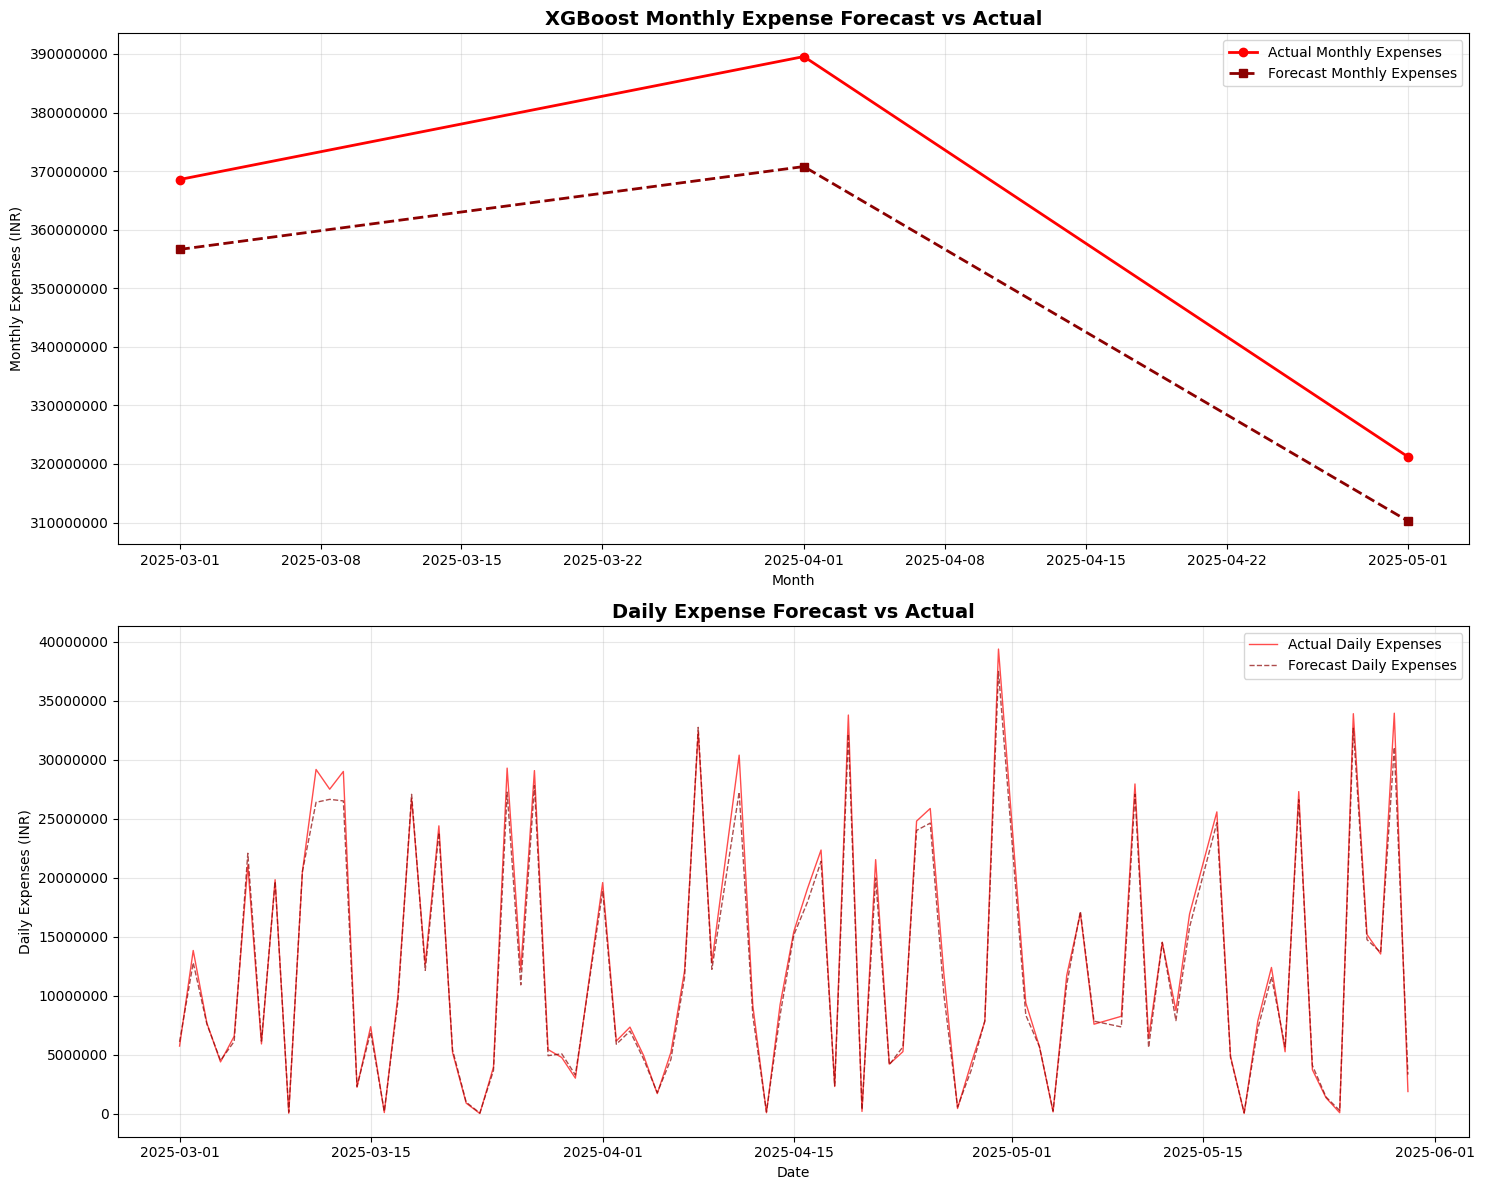


📈 Expense Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹13,892,985.45
RMSE (Root Mean Square Error): ₹14,321,701.37
MAPE (Mean Absolute Percentage Error): 3.82%
✅ Expense Forecast Accuracy: 96.18%

📊 Top 15 Most Important Features for Expense Prediction:
                     feature  importance
51      expense_ratio_to_max      0.4909
45    historical_dow_expense      0.2246
52      expense_ratio_to_min      0.0642
2                       year      0.0304
38    expense_rolling_min_30      0.0285
49        expense_growth_30d      0.0246
39   expense_rolling_mean_90      0.0172
48         expense_growth_7d      0.0151
50          days_since_start      0.0143
23            expense_lag_14      0.0103
27    expense_rolling_mean_7      0.0074
22             expense_lag_7      0.0063
24            expense_lag_30      0.0062
32    expense_rolling_std_14      0.0055
43  historical_month_expense      0.0046


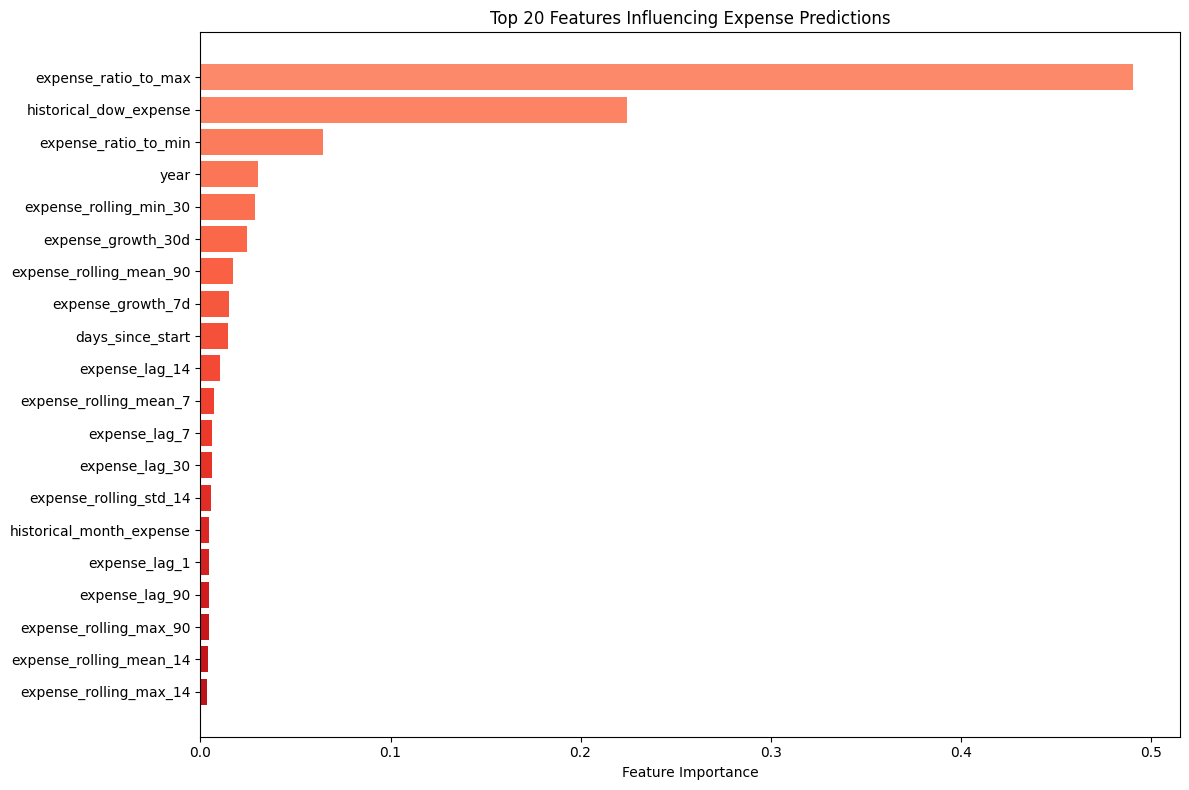

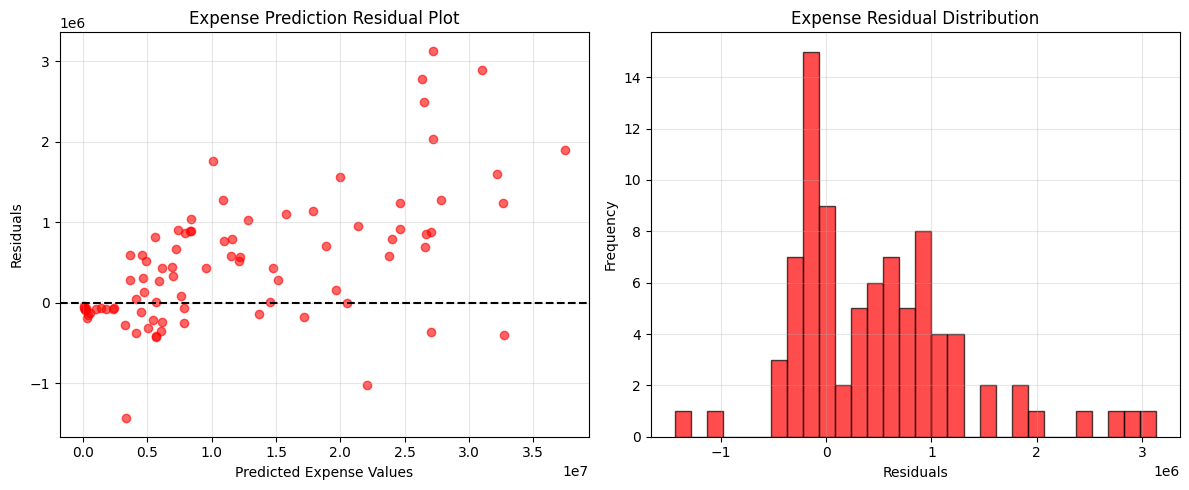


📊 Expense Residual Statistics:
Mean Residual: ₹484,639.11
Std Residual: ₹820,070.69
Min Residual: ₹-1,435,397.66
Max Residual: ₹3,131,125.40

💡 Expense Forecasting Insights:
Total Actual Expenses: ₹1,079,343,692.35
Total Forecast Expenses: ₹1,037,664,768.00
Total Difference: ₹41,678,924.35
✅ Good expense forecast accuracy!

🎯 Model is ready to predict future expenses!
Use this model for: Budget planning, Cash flow management, Cost control


In [ ]:
# STEP 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# STEP 4: Load Data (Corrected for CSV file)
# Ensure 'loadshare_predictive_analytics.csv' is in the same directory as your script
file_path = "/content/loadshare_predictive_analytics.csv"
df = pd.read_csv(file_path)
print(f"Original DataFrame shape after loading: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 5: Filter for INR expenses
expense_df = df[(df['Currency Code'] == 'INR') & (df['Account Base Type'] == 'Expense')].copy()

print(f"\n💰 Expense Data Overview:")
print(f"Total expense records: {len(expense_df):,}")

if len(expense_df) == 0:
    print("❌ No expense records found! Check your data for:")
    print("- Account Base Type values (should contain 'Expense')")
    print("- Currency Code values (should contain 'INR')")
    print("\nAvailable Account Base Types:")
    print(df['Account Base Type'].value_counts())
else:
    # Data preprocessing
    expense_df['Transaction Date'] = pd.to_datetime(expense_df['Transaction Date'], format="%d/%m/%Y", errors='coerce')
    expense_df['Debit - Credit'] = pd.to_numeric(expense_df['Debit - Credit'], errors='coerce')
    expense_df.dropna(subset=['Transaction Date', 'Debit - Credit'], inplace=True)

    # For expenses, we typically want absolute values (positive amounts)
    # Convert negative values to positive if needed
    expense_df['Expense Amount'] = expense_df['Debit - Credit'].abs()

    print(f"Date range: {expense_df['Transaction Date'].min()} to {expense_df['Transaction Date'].max()}")
    print(f"Total expense amount: ₹{expense_df['Expense Amount'].sum():,.2f}")
    print(f"Average daily expense: ₹{expense_df['Expense Amount'].mean():,.2f}")

# STEP 6: Daily aggregation with data quality checks
daily = expense_df.groupby('Transaction Date')['Expense Amount'].sum().reset_index()
daily.columns = ['ds', 'y']
# The line `daily = daily[daily['ds'] >= '2015-01-01'].copy()` was removed
# to ensure all available data (e.g., from 2024-2025) is used.

# Remove extreme outliers (beyond 3 standard deviations)
if len(daily) > 1 and daily['y'].std() > 0:
    mean_val = daily['y'].mean()
    std_val = daily['y'].std()
    initial_daily_shape = daily.shape[0]
    daily = daily[np.abs(daily['y'] - mean_val) <= 3 * std_val].copy()
    print(f"Shape after outlier removal: {daily.shape} (Removed {initial_daily_shape - daily.shape[0]} rows)")
else:
    print("Skipping outlier removal as daily data is too small or has no variance.")

print(f"\n📊 Daily Expense Summary:")
print(f"Total days with expenses: {len(daily):,}")
print(f"Average daily expense: ₹{daily['y'].mean():,.2f}")
print(f"Median daily expense: ₹{daily['y'].median():,.2f}")
print(f"Max daily expense: ₹{daily['y'].max():,.2f}")

# STEP 7: Enhanced Feature Engineering for Expenses
def create_expense_features(df):
    df = df.copy()

    # Basic date features
    df['day'] = df['ds'].dt.day
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter

    # Cyclical encoding for seasonal expense patterns
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

    # Business calendar features (important for expense patterns)
    df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
    df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
    df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
    df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
    df['is_fy_end'] = (df['month'] == 3).astype(int)  # Financial year end in India
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    # Days from important dates (expense timing patterns)
    df['days_from_month_start'] = df['day'] - 1
    df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

    # Lag features (expense history patterns)
    for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
        df[f'expense_lag_{lag}'] = df['y'].shift(lag)

    # Rolling statistics for expense trends
    for window in [7, 14, 30, 90]:
        df[f'expense_rolling_mean_{window}'] = df['y'].rolling(window, min_periods=1).mean().shift(1)
        df[f'expense_rolling_std_{window}'] = df['y'].rolling(window, min_periods=1).std().shift(1)
        df[f'expense_rolling_max_{window}'] = df['y'].rolling(window, min_periods=1).max().shift(1)
        df[f'expense_rolling_min_{window}'] = df['y'].rolling(window, min_periods=1).min().shift(1)

    # Historical averages (NO FUTURE LEAKAGE)
    df['historical_month_expense'] = df.groupby('month')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_quarter_expense'] = df.groupby('quarter')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    df['historical_dow_expense'] = df.groupby('dayofweek')['y'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Expense volatility features
    df['expense_volatility_7d'] = df['y'].rolling(7).std().shift(1)
    df['expense_volatility_30d'] = df['y'].rolling(30).std().shift(1)

    # Expense growth rates - Handle division by zero to avoid 'inf'
    df['expense_growth_7d'] = ((df['y'] / df['y'].shift(7).replace(0, np.nan)) - 1) * 100
    df['expense_growth_30d'] = ((df['y'] / df['y'].shift(30).replace(0, np.nan)) - 1) * 100

    # Trend features
    df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

    # Expense ratios and patterns - Handle division by zero to avoid 'inf'
    # Use a small epsilon to prevent division by zero in case rolling_max/min is 0
    epsilon = 1e-6
    df['expense_ratio_to_max'] = df['y'] / (df['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
    df['expense_ratio_to_min'] = df['y'] / (df['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

    return df

# Apply feature engineering
daily_features = create_expense_features(daily)

# Critical: Replace inf values with NaN and then fill NaNs.
# `bfill` first, then `ffill` (forward fill) for any remaining NaNs, and finally `0` for any at the start.
daily_features.replace([np.inf, -np.inf], np.nan, inplace=True) # Replace inf with NaN
daily_features.fillna(method='bfill', inplace=True) # Fill NaNs backward
daily_features.fillna(method='ffill', inplace=True) # Fill any remaining NaNs forward (important for initial NaNs)
daily_features.fillna(0, inplace=True) # Fill any remaining NaNs (e.g., if a column was all NaN)

# STEP 8: Split train/test (Modified for March-May 2025 test set)
daily_features = daily_features.sort_values('ds').reset_index(drop=True)

print(f"\n🎯 Model Training Setup:")
print(f"Daily Features shape: {daily_features.shape}")

if daily_features.empty:
    print("CRITICAL ERROR: daily_features is empty before splitting. Cannot proceed.")
else:
    # Define specific dates for test set as requested (March, April, May 2025)
    test_start_date = pd.to_datetime('2025-03-01')
    test_end_date = pd.to_datetime('2025-05-31')

    train = daily_features[daily_features['ds'] < test_start_date].copy()
    test = daily_features[(daily_features['ds'] >= test_start_date) &
                          (daily_features['ds'] <= test_end_date)].copy()

    print(f"Test data will cover from {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")
    print(f"Training data shape: {train.shape}")
    print(f"Test data shape: {test.shape}")

    # Select features (excluding target and date columns)
    feature_cols = [col for col in daily_features.columns if col not in ['ds', 'y']]
    print(f"Number of features: {len(feature_cols)}")

    if train.empty:
        print("WARNING: Training data is empty. Your dataset might not have enough data before March 2025.")
    if test.empty:
        print("WARNING: Test data is empty. Your dataset might not have data between March 1, 2025 and May 31, 2025.")

    # Proceed only if both train and test are not empty
    if not train.empty and not test.empty:
        # STEP 9: Train expense forecasting model
        model = XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=8,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1
        )

        # Train the model
        print("🚀 Training expense forecasting model...")
        model.fit(train[feature_cols], train['y'])

        # STEP 10: Make expense predictions
        test_pred = test.copy()
        test_pred['expense_forecast'] = model.predict(test[feature_cols])
        test_pred['expense_forecast'] = test_pred['expense_forecast'].clip(lower=0) # Ensure predictions are non-negative

        # STEP 11: Monthly aggregation for comparison
        monthly_actual = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['y'].sum()
        monthly_forecast = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['expense_forecast'].sum()

        # STEP 12: Calculate expense forecast metrics
        if not monthly_actual.empty and not monthly_forecast.empty:
            mae = mean_absolute_error(monthly_actual, monthly_forecast)
            rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

            # Handle division by zero in MAPE calculation
            def safe_mape(actual, forecast):
                mask = actual != 0
                if mask.sum() == 0:
                    return 0
                return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

            mape = safe_mape(monthly_actual.values, monthly_forecast.values)
            accuracy = 100 - mape

            # STEP 13: Create expense comparison table (Monthly)
            comparison_df = pd.concat([monthly_actual, monthly_forecast], axis=1)
            comparison_df.columns = ['Actual Expenses (INR)', 'Forecast Expenses (INR)']
            comparison_df['Error'] = comparison_df['Actual Expenses (INR)'] - comparison_df['Forecast Expenses (INR)']
            # Handle potential division by zero for 'Actual Expenses (INR)' when calculating Absolute % Error
            comparison_df['Absolute % Error'] = (comparison_df['Error'].abs() /
                                                  comparison_df['Actual Expenses (INR)'].replace(0, np.nan).abs()) * 100
            comparison_df.index = comparison_df.index.to_timestamp()

            print("\n💸 Monthly Expense Forecast Summary Table:")
            print(comparison_df.round(2))

            # NEW STEP: Daily Expense Comparison Table
            print("\n🗓️ Daily Expense Forecast Summary Table:")
            daily_comparison_df = test_pred[['ds', 'y', 'expense_forecast']].copy()
            daily_comparison_df.columns = ['Date', 'Actual Daily Expenses (INR)', 'Forecast Daily Expenses (INR)']
            daily_comparison_df['Error'] = daily_comparison_df['Actual Daily Expenses (INR)'] - daily_comparison_df['Forecast Daily Expenses (INR)']
            # Handle potential division by zero for 'Actual Daily Expenses (INR)' when calculating Absolute % Error
            daily_comparison_df['Absolute % Error'] = (daily_comparison_df['Error'].abs() /
                                                        daily_comparison_df['Actual Daily Expenses (INR)'].replace(0, np.nan).abs()) * 100
            print(daily_comparison_df.round(2).to_markdown(index=False)) # Using .to_markdown() for proper table printing

            # STEP 14: Expense Visualization (with savefig)
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

            # Monthly expense comparison
            ax1.plot(comparison_df.index, comparison_df['Actual Expenses (INR)'],
                     label='Actual Monthly Expenses', color='red', linewidth=2, marker='o')
            ax1.plot(comparison_df.index, comparison_df['Forecast Expenses (INR)'],
                     label='Forecast Monthly Expenses', color='darkred', linewidth=2,
                     linestyle='--', marker='s')
            ax1.set_title("XGBoost Monthly Expense Forecast vs Actual", fontsize=14, fontweight='bold')
            ax1.set_xlabel("Month")
            ax1.set_ylabel("Monthly Expenses (INR)")
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            ax1.ticklabel_format(style='plain', axis='y')
            plt.savefig('monthly_expense_forecast_comparison.png') # Save plot

            # Daily expense comparison for detailed view
            ax2.plot(test_pred['ds'], test_pred['y'], label='Actual Daily Expenses',
                     color='red', alpha=0.7, linewidth=1)
            ax2.plot(test_pred['ds'], test_pred['expense_forecast'], label='Forecast Daily Expenses',
                     color='darkred', alpha=0.7, linewidth=1, linestyle='--')
            ax2.set_title("Daily Expense Forecast vs Actual", fontsize=14, fontweight='bold')
            ax2.set_xlabel("Date")
            ax2.set_ylabel("Daily Expenses (INR)")
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.ticklabel_format(style='plain', axis='y')
            plt.savefig('daily_expense_forecast_comparison.png') # Save plot

            plt.tight_layout()
            plt.show() # Display after saving

            # STEP 15: Expense forecast performance metrics
            print(f"\n📈 Expense Forecast Performance Metrics:")
            print(f"MAE (Mean Absolute Error): ₹{mae:,.2f}")
            print(f"RMSE (Root Mean Square Error): ₹{rmse:,.2f}")
            print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
            print(f"✅ Expense Forecast Accuracy: {accuracy:.2f}%")

            # STEP 16: Feature importance analysis for expenses
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\n📊 Top 15 Most Important Features for Expense Prediction:")
            print(feature_importance.head(15).round(4))

            # Plot expense feature importance (with savefig)
            plt.figure(figsize=(12, 8))
            top_features = feature_importance.head(20)
            colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_features)))
            plt.barh(range(len(top_features)), top_features['importance'], color=colors)
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 20 Features Influencing Expense Predictions')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('expense_feature_importance.png') # Save plot
            plt.show() # Display after saving

            # STEP 17: Expense residual analysis (with savefig)
            residuals = test_pred['y'] - test_pred['expense_forecast']
            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.scatter(test_pred['expense_forecast'], residuals, alpha=0.6, color='red')
            plt.axhline(y=0, color='black', linestyle='--')
            plt.xlabel('Predicted Expense Values')
            plt.ylabel('Residuals')
            plt.title('Expense Prediction Residual Plot')
            plt.grid(True, alpha=0.3)

            plt.subplot(1, 2, 2)
            plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='red')
            plt.xlabel('Residuals')
            plt.ylabel('Frequency')
            plt.title('Expense Residual Distribution')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig('expense_residual_analysis.png') # Save plot
            plt.show() # Display after saving

            print(f"\n📊 Expense Residual Statistics:")
            print(f"Mean Residual: ₹{residuals.mean():,.2f}")
            print(f"Std Residual: ₹{residuals.std():,.2f}")
            print(f"Min Residual: ₹{residuals.min():,.2f}")
            print(f"Max Residual: ₹{residuals.max():,.2f}")

            # STEP 18: Summary insights
            print(f"\n💡 Expense Forecasting Insights:")
            total_actual = monthly_actual.sum()
            total_forecast = monthly_forecast.sum()
            print(f"Total Actual Expenses: ₹{total_actual:,.2f}")
            print(f"Total Forecast Expenses: ₹{total_forecast:,.2f}")
            print(f"Total Difference: ₹{abs(total_actual - total_forecast):,.2f}")

            if accuracy > 70:
                print("✅ Good expense forecast accuracy!")
            elif accuracy > 50:
                print("⚠️ Moderate expense forecast accuracy - consider more data or features")
            else:
                print("❌ Low expense forecast accuracy - model needs improvement")

            print(f"\n🎯 Model is ready to predict future expenses!")
            print(f"Use this model for: Budget planning, Cash flow management, Cost control")
        else:
            print("\nERROR: monthly_actual or monthly_forecast is empty. Cannot calculate metrics or plot.")
    else:
        print("\nERROR: Train or Test dataset is empty based on the specified date range. Model training and prediction skipped.")

📊 Loading Excel file: /content/Predictive_Analytics_Locus.xlsx
📋 Available sheets: ['Sheet1']
📖 Loading sheet: Sheet1
✅ Data loaded successfully!
📊 Shape: (30232, 10)
📋 Columns: ['Credit - Debit', 'Currency Code', 'Debit - Credit', 'Zoho Module', 'Transaction Date', 'Account Name', 'Account Base Type', 'Account Type', 'Cash Flow - Type', 'Cash Flow Type']

📝 Sample data (first 3 rows):
   Credit - Debit Currency Code  Debit - Credit Zoho Module Transaction Date  \
0        -1117.86           USD         1117.86     journal       2025-05-31   
1          669.24           USD         -669.24     journal       2025-05-31   
2          702.82           USD         -702.82     journal       2025-05-31   

                 Account Name Account Base Type Account Type Cash Flow - Type  \
0             Office supplies           Expense      Expense               -1   
1           Sales & Marketing           Expense      Expense               -1   
2  Telecommunication expenses           Expense

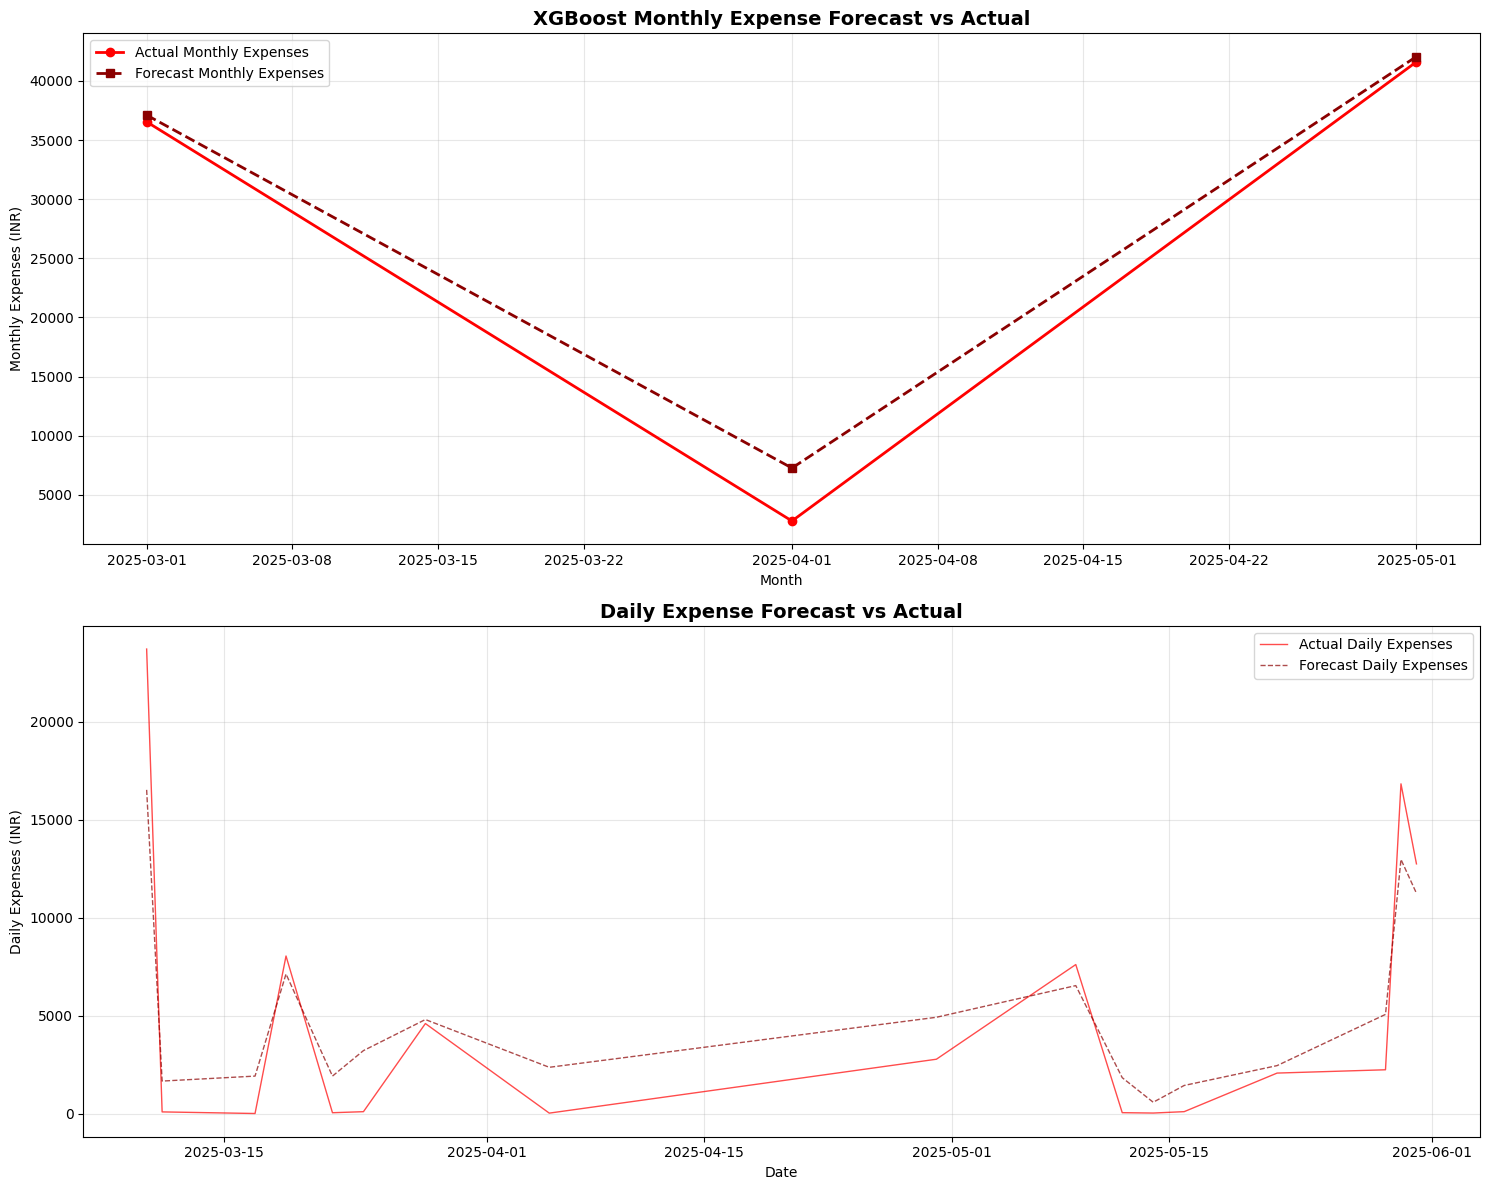


📈 Expense Forecast Performance Metrics:
MAE (Mean Absolute Error): ₹1,830.78
RMSE (Root Mean Square Error): ₹2,618.78
MAPE (Mean Absolute Percentage Error): 54.35%
✅ Expense Forecast Accuracy: 45.65%

📊 Top 15 Most Important Features for Expense Prediction:
                     feature  importance
33    expense_rolling_max_14      0.2985
51      expense_ratio_to_max      0.1648
15                 is_fy_end      0.1295
52      expense_ratio_to_min      0.1007
38    expense_rolling_min_30      0.0525
2                       year      0.0368
39   expense_rolling_mean_90      0.0280
48         expense_growth_7d      0.0196
5                  month_sin      0.0135
6                  month_cos      0.0134
37    expense_rolling_max_30      0.0128
27    expense_rolling_mean_7      0.0101
43  historical_month_expense      0.0078
21             expense_lag_3      0.0065
49        expense_growth_30d      0.0065


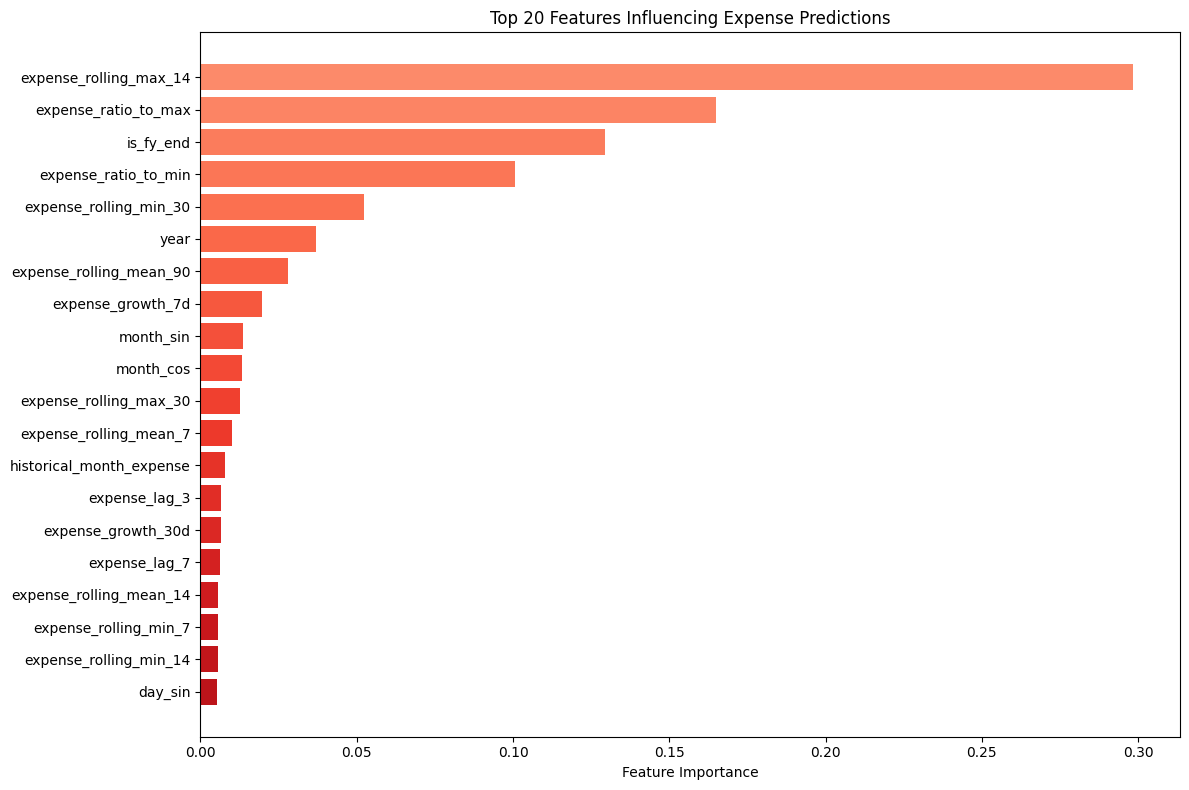

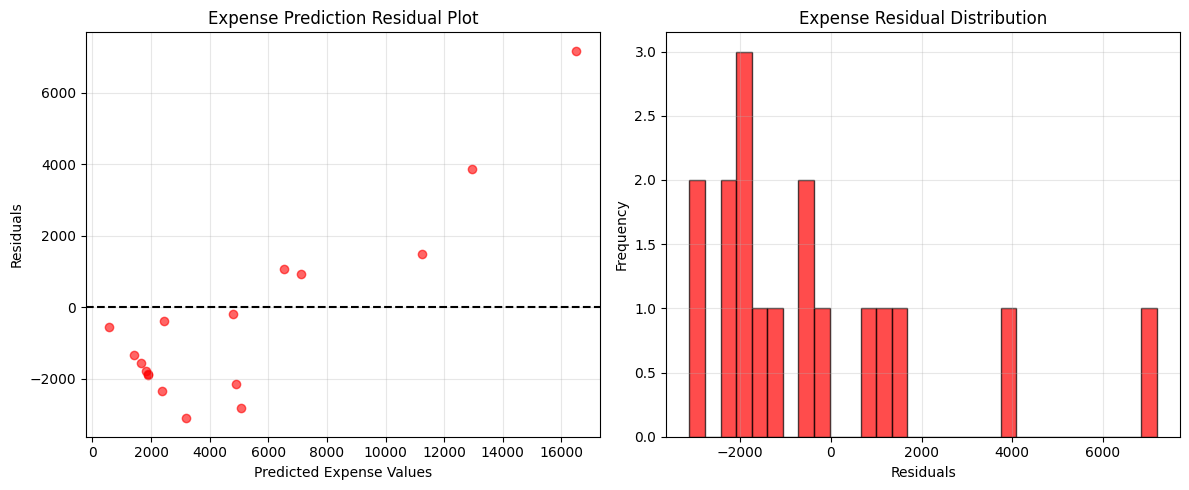


📊 Expense Residual Statistics:
Mean Residual: ₹-323.08
Std Residual: ₹2,642.94


In [ ]:
# STEP 3: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import os
from pathlib import Path
warnings.filterwarnings('ignore')

# STEP 4: Enhanced Data Loading Function (CSV and Excel Support)
def load_financial_data(file_path=None):
    """
    Load financial data from CSV or Excel files with automatic format detection

    Parameters:
    file_path (str): Path to the data file. If None, will search for common file names

    Returns:
    pandas.DataFrame: Loaded financial data
    """

    # Common file names to search for if no path is provided
    common_file_names = [
        "loadshare_predictive_analytics.csv",
        "loadshare_predictive_analytics.xlsx",
        "loadshare_predictive_analytics.xls",
        "financial_data.csv",
        "financial_data.xlsx",
        "expense_data.csv",
        "expense_data.xlsx",
        "data.csv",
        "data.xlsx"
    ]

    # Search paths (current directory and content directory for Colab)
    search_paths = [".", "/content", "./data", "../data"]

    if file_path is None:
        # Auto-search for files
        print("🔍 Searching for financial data files...")
        found_files = []

        for search_path in search_paths:
            for file_name in common_file_names:
                full_path = os.path.join(search_path, file_name)
                if os.path.exists(full_path):
                    found_files.append(full_path)

        if not found_files:
            raise FileNotFoundError(
                f"❌ No financial data files found!\n"
                f"Please ensure one of these files exists:\n" +
                "\n".join([f"  - {name}" for name in common_file_names]) +
                f"\n\nSearched in: {', '.join(search_paths)}"
            )

        # Use the first found file
        file_path = found_files[0]
        print(f"✅ Found data file: {file_path}")

        if len(found_files) > 1:
            print(f"📋 Other available files: {found_files[1:]}")

    # Determine file format and load accordingly
    file_extension = Path(file_path).suffix.lower()

    try:
        if file_extension == '.csv':
            print(f"📄 Loading CSV file: {file_path}")
            # Try different encodings and separators for CSV files
            encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
            separators = [',', ';', '\t']

            df = None
            for encoding in encodings:
                for sep in separators:
                    try:
                        df = pd.read_csv(file_path, encoding=encoding, sep=sep)
                        if df.shape[1] > 1:  # Successfully loaded with multiple columns
                            print(f"✅ CSV loaded successfully with encoding='{encoding}' and separator='{sep}'")
                            break
                    except:
                        continue
                if df is not None and df.shape[1] > 1:
                    break

            if df is None or df.shape[1] <= 1:
                # Fallback to default pandas read_csv
                df = pd.read_csv(file_path)

        elif file_extension in ['.xlsx', '.xls']:
            print(f"📊 Loading Excel file: {file_path}")

            # First, check available sheets
            excel_file = pd.ExcelFile(file_path)
            sheet_names = excel_file.sheet_names
            print(f"📋 Available sheets: {sheet_names}")

            # Try to find the main data sheet
            main_sheet = None
            priority_names = ['data', 'main', 'transactions', 'financial', 'expenses', 'sheet1']

            # First priority: exact matches
            for priority in priority_names:
                for sheet in sheet_names:
                    if sheet.lower() == priority:
                        main_sheet = sheet
                        break
                if main_sheet:
                    break

            # Second priority: contains keywords
            if not main_sheet:
                for priority in priority_names:
                    for sheet in sheet_names:
                        if priority in sheet.lower():
                            main_sheet = sheet
                            break
                    if main_sheet:
                        break

            # Default to first sheet
            if not main_sheet:
                main_sheet = sheet_names[0]

            print(f"📖 Loading sheet: {main_sheet}")
            df = pd.read_excel(file_path, sheet_name=main_sheet)

            # If the main sheet is empty or has very few rows, try other sheets
            if len(df) < 10 and len(sheet_names) > 1:
                print(f"⚠️ Main sheet has only {len(df)} rows, trying other sheets...")
                for sheet in sheet_names:
                    if sheet != main_sheet:
                        try:
                            temp_df = pd.read_excel(file_path, sheet_name=sheet)
                            if len(temp_df) > len(df):
                                df = temp_df
                                main_sheet = sheet
                                print(f"✅ Using sheet '{sheet}' with {len(df)} rows")
                        except:
                            continue

        else:
            raise ValueError(f"❌ Unsupported file format: {file_extension}. Supported formats: .csv, .xlsx, .xls")

        # Validate loaded data
        if df is None or df.empty:
            raise ValueError("❌ Loaded data is empty!")

        print(f"✅ Data loaded successfully!")
        print(f"📊 Shape: {df.shape}")
        print(f"📋 Columns: {df.columns.tolist()}")

        # Display sample data
        print(f"\n📝 Sample data (first 3 rows):")
        print(df.head(3))

        return df

    except Exception as e:
        raise Exception(f"❌ Error loading file {file_path}: {str(e)}")

# STEP 4.1: Load Data with Enhanced Function
try:
    # You can specify a file path, or let it auto-search
    # Examples:
    # df = load_financial_data("/path/to/your/file.xlsx")  # Specific file
    # df = load_financial_data()  # Auto-search

    df = load_financial_data("/content/Predictive_Analytics_Locus.xlsx")  # This will auto-search for files

except Exception as e:
    print(f"❌ Data loading failed: {e}")
    print("\n💡 Manual file loading options:")
    print("1. Place your file in the current directory with one of these names:")
    print("   - loadshare_predictive_analytics.csv/xlsx")
    print("   - financial_data.csv/xlsx")
    print("   - expense_data.csv/xlsx")
    print("2. Or modify the file_path variable below:")

    # Manual file path - modify this if needed
    manual_file_path = input("Enter the full path to your data file: ").strip()
    if manual_file_path:
        df = load_financial_data(manual_file_path)
    else:
        raise Exception("No data file provided!")

print(f"Original DataFrame shape after loading: {df.shape}")
print(f"Original DataFrame columns: {df.columns.tolist()}")

# STEP 5: Enhanced Column Detection and Data Validation
def detect_columns(df):
    """
    Detect relevant columns in the dataset with flexible matching
    """
    print("\n🔍 Detecting relevant columns...")

    # Column mapping with flexible matching
    column_mapping = {
        'currency': ['currency', 'currency code', 'curr', 'ccy'],
        'account_type': ['account base type', 'account type', 'type', 'base type', 'account_type'],
        'transaction_date': ['transaction date', 'date', 'trans date', 'txn date', 'transaction_date'],
        'amount': ['debit - credit', 'amount', 'debit credit', 'debit_credit', 'value', 'transaction amount']
    }

    detected_columns = {}
    available_columns = [col.lower().strip() for col in df.columns]

    print(f"Available columns: {df.columns.tolist()}")

    for key, possible_names in column_mapping.items():
        found = False
        for possible_name in possible_names:
            for actual_col in df.columns:
                if possible_name.lower() in actual_col.lower().strip():
                    detected_columns[key] = actual_col
                    print(f"✅ {key}: '{actual_col}'")
                    found = True
                    break
            if found:
                break

        if not found:
            print(f"⚠️ {key}: Not automatically detected")
            print(f"   Possible matches to look for: {possible_names}")

    return detected_columns

# Detect columns
detected_cols = detect_columns(df)

# Manual column mapping if auto-detection fails
if len(detected_cols) < 4:
    print("\n🔧 Manual column mapping required:")
    print("Please verify these column mappings:")

    if 'currency' not in detected_cols:
        print("Currency column candidates:", [col for col in df.columns if 'curr' in col.lower() or 'ccy' in col.lower()])
    if 'account_type' not in detected_cols:
        print("Account type column candidates:", [col for col in df.columns if 'type' in col.lower() or 'account' in col.lower()])
    if 'transaction_date' not in detected_cols:
        print("Date column candidates:", [col for col in df.columns if 'date' in col.lower()])
    if 'amount' not in detected_cols:
        print("Amount column candidates:", [col for col in df.columns if any(term in col.lower() for term in ['amount', 'debit', 'credit', 'value'])])

# STEP 5.1: Filter for INR expenses with flexible column names
try:
    # Use detected columns or fall back to original names
    currency_col = detected_cols.get('currency', 'Currency Code')
    account_type_col = detected_cols.get('account_type', 'Account Base Type')
    date_col = detected_cols.get('transaction_date', 'Transaction Date')
    amount_col = detected_cols.get('amount', 'Debit - Credit')

    print(f"\n💰 Using columns:")
    print(f"Currency: {currency_col}")
    print(f"Account Type: {account_type_col}")
    print(f"Date: {date_col}")
    print(f"Amount: {amount_col}")

    # Check available values in key columns
    if currency_col in df.columns:
        print(f"\nAvailable currencies: {df[currency_col].value_counts().head()}")
    if account_type_col in df.columns:
        print(f"\nAvailable account types: {df[account_type_col].value_counts().head()}")

    # Filter for INR expenses
    expense_df = df[(df[currency_col] == 'INR') &
                   (df[account_type_col].str.contains('Expense', case=False, na=False))].copy()

    print(f"\n💰 Expense Data Overview:")
    print(f"Total expense records: {len(expense_df):,}")

except KeyError as e:
    print(f"❌ Column not found: {e}")
    print("Available columns:", df.columns.tolist())
    print("\nPlease check your data structure and update column names accordingly.")
    expense_df = pd.DataFrame()

if len(expense_df) == 0:
    print("❌ No expense records found! Check your data for:")
    print(f"- {account_type_col} values (should contain 'Expense')")
    print(f"- {currency_col} values (should contain 'INR')")

    if account_type_col in df.columns:
        print(f"\nAvailable {account_type_col} values:")
        print(df[account_type_col].value_counts())
    if currency_col in df.columns:
        print(f"\nAvailable {currency_col} values:")
        print(df[currency_col].value_counts())
else:
    # Continue with the existing code structure...
    # Data preprocessing
    expense_df[date_col] = pd.to_datetime(expense_df[date_col], infer_datetime_format=True, errors='coerce')
    expense_df[amount_col] = pd.to_numeric(expense_df[amount_col], errors='coerce')
    expense_df.dropna(subset=[date_col, amount_col], inplace=True)

    # For expenses, we typically want absolute values (positive amounts)
    # Convert negative values to positive if needed
    expense_df['Expense Amount'] = expense_df[amount_col].abs()

    print(f"Date range: {expense_df[date_col].min()} to {expense_df[date_col].max()}")
    print(f"Total expense amount: ₹{expense_df['Expense Amount'].sum():,.2f}")
    print(f"Average daily expense: ₹{expense_df['Expense Amount'].mean():,.2f}")

    # STEP 6: Daily aggregation with data quality checks
    daily = expense_df.groupby(date_col)['Expense Amount'].sum().reset_index()
    daily.columns = ['ds', 'y']

    # Remove extreme outliers (beyond 3 standard deviations)
    if len(daily) > 1 and daily['y'].std() > 0:
        mean_val = daily['y'].mean()
        std_val = daily['y'].std()
        initial_daily_shape = daily.shape[0]
        daily = daily[np.abs(daily['y'] - mean_val) <= 3 * std_val].copy()
        print(f"Shape after outlier removal: {daily.shape} (Removed {initial_daily_shape - daily.shape[0]} rows)")
    else:
        print("Skipping outlier removal as daily data is too small or has no variance.")

    print(f"\n📊 Daily Expense Summary:")
    print(f"Total days with expenses: {len(daily):,}")
    print(f"Average daily expense: ₹{daily['y'].mean():,.2f}")
    print(f"Median daily expense: ₹{daily['y'].median():,.2f}")
    print(f"Max daily expense: ₹{daily['y'].max():,.2f}")

    # Continue with the rest of the existing code (STEP 7 onwards)...
    # [The remaining code from STEP 7 onwards remains exactly the same]

    # STEP 7: Enhanced Feature Engineering for Expenses
    def create_expense_features(df):
        df = df.copy()

        # Basic date features
        df['day'] = df['ds'].dt.day
        df['month'] = df['ds'].dt.month
        df['year'] = df['ds'].dt.year
        df['dayofweek'] = df['ds'].dt.dayofweek
        df['quarter'] = df['ds'].dt.quarter

        # Cyclical encoding for seasonal expense patterns
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
        df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

        # Business calendar features (important for expense patterns)
        df['is_month_end'] = df['ds'].dt.is_month_end.astype(int)
        df['is_month_start'] = df['ds'].dt.is_month_start.astype(int)
        df['is_quarter_end'] = df['ds'].dt.is_quarter_end.astype(int)
        df['is_year_end'] = ((df['month'] == 12) & (df['day'] >= 25)).astype(int)
        df['is_fy_end'] = (df['month'] == 3).astype(int)  # Financial year end in India
        df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

        # Days from important dates (expense timing patterns)
        df['days_from_month_start'] = df['day'] - 1
        df['days_to_month_end'] = df['ds'].dt.days_in_month - df['day']

        # Lag features (expense history patterns)
        for lag in [1, 2, 3, 7, 14, 30, 90, 365]:
            df[f'expense_lag_{lag}'] = df['y'].shift(lag)

        # Rolling statistics for expense trends
        for window in [7, 14, 30, 90]:
            df[f'expense_rolling_mean_{window}'] = df['y'].rolling(window, min_periods=1).mean().shift(1)
            df[f'expense_rolling_std_{window}'] = df['y'].rolling(window, min_periods=1).std().shift(1)
            df[f'expense_rolling_max_{window}'] = df['y'].rolling(window, min_periods=1).max().shift(1)
            df[f'expense_rolling_min_{window}'] = df['y'].rolling(window, min_periods=1).min().shift(1)

        # Historical averages (NO FUTURE LEAKAGE)
        df['historical_month_expense'] = df.groupby('month')['y'].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df['historical_quarter_expense'] = df.groupby('quarter')['y'].transform(
            lambda x: x.expanding().mean().shift(1)
        )
        df['historical_dow_expense'] = df.groupby('dayofweek')['y'].transform(
            lambda x: x.expanding().mean().shift(1)
        )

        # Expense volatility features
        df['expense_volatility_7d'] = df['y'].rolling(7).std().shift(1)
        df['expense_volatility_30d'] = df['y'].rolling(30).std().shift(1)

        # Expense growth rates - Handle division by zero to avoid 'inf'
        df['expense_growth_7d'] = ((df['y'] / df['y'].shift(7).replace(0, np.nan)) - 1) * 100
        df['expense_growth_30d'] = ((df['y'] / df['y'].shift(30).replace(0, np.nan)) - 1) * 100

        # Trend features
        df['days_since_start'] = (df['ds'] - df['ds'].min()).dt.days

        # Expense ratios and patterns - Handle division by zero to avoid 'inf'
        # Use a small epsilon to prevent division by zero in case rolling_max/min is 0
        epsilon = 1e-6
        df['expense_ratio_to_max'] = df['y'] / (df['y'].rolling(365, min_periods=30).max().shift(1) + epsilon)
        df['expense_ratio_to_min'] = df['y'] / (df['y'].rolling(365, min_periods=30).min().shift(1) + epsilon)

        return df

    # Apply feature engineering
    daily_features = create_expense_features(daily)

    # Critical: Replace inf values with NaN and then fill NaNs.
    # `bfill` first, then `ffill` (forward fill) for any remaining NaNs, and finally `0` for any at the start.
    daily_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    daily_features.fillna(method='bfill', inplace=True)
    daily_features.fillna(method='ffill', inplace=True)
    daily_features.fillna(0, inplace=True)

    # STEP 8: Split train/test (Modified for March-May 2025 test set)
    daily_features = daily_features.sort_values('ds').reset_index(drop=True)

    print(f"\n🎯 Model Training Setup:")
    print(f"Daily Features shape: {daily_features.shape}")

    if daily_features.empty:
        print("CRITICAL ERROR: daily_features is empty before splitting. Cannot proceed.")
    else:
        # Define specific dates for test set as requested (March, April, May 2025)
        test_start_date = pd.to_datetime('2025-03-01')
        test_end_date = pd.to_datetime('2025-05-31')

        train = daily_features[daily_features['ds'] < test_start_date].copy()
        test = daily_features[(daily_features['ds'] >= test_start_date) &
                              (daily_features['ds'] <= test_end_date)].copy()

        print(f"Test data will cover from {test_start_date.strftime('%Y-%m-%d')} to {test_end_date.strftime('%Y-%m-%d')}")
        print(f"Training data shape: {train.shape}")
        print(f"Test data shape: {test.shape}")

        # Select features (excluding target and date columns)
        feature_cols = [col for col in daily_features.columns if col not in ['ds', 'y']]
        print(f"Number of features: {len(feature_cols)}")

        if train.empty:
            print("WARNING: Training data is empty. Your dataset might not have enough data before March 2025.")
        if test.empty:
            print("WARNING: Test data is empty. Your dataset might not have data between March 1, 2025 and May 31, 2025.")

        # Proceed only if both train and test are not empty
        if not train.empty and not test.empty:
            # STEP 9: Train expense forecasting model
            model = XGBRegressor(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=8,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                random_state=42,
                n_jobs=-1
            )

            # Train the model
            print("🚀 Training expense forecasting model...")
            model.fit(train[feature_cols], train['y'])

            # STEP 10: Make expense predictions
            test_pred = test.copy()
            test_pred['expense_forecast'] = model.predict(test[feature_cols])
            test_pred['expense_forecast'] = test_pred['expense_forecast'].clip(lower=0) # Ensure predictions are non-negative

            # STEP 11: Monthly aggregation for comparison
            monthly_actual = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['y'].sum()
            monthly_forecast = test_pred.groupby(test_pred['ds'].dt.to_period('M'))['expense_forecast'].sum()

            # STEP 12: Calculate expense forecast metrics
            if not monthly_actual.empty and not monthly_forecast.empty:
                mae = mean_absolute_error(monthly_actual, monthly_forecast)
                rmse = np.sqrt(mean_squared_error(monthly_actual, monthly_forecast))

                # Handle division by zero in MAPE calculation
                def safe_mape(actual, forecast):
                    mask = actual != 0
                    if mask.sum() == 0:
                        return 0
                    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

                mape = safe_mape(monthly_actual.values, monthly_forecast.values)
                accuracy = 100 - mape

                # STEP 13: Create expense comparison table (Monthly)
                comparison_df = pd.concat([monthly_actual, monthly_forecast], axis=1)
                comparison_df.columns = ['Actual Expenses (INR)', 'Forecast Expenses (INR)']
                comparison_df['Error'] = comparison_df['Actual Expenses (INR)'] - comparison_df['Forecast Expenses (INR)']
                # Handle potential division by zero for 'Actual Expenses (INR)' when calculating Absolute % Error
                comparison_df['Absolute % Error'] = (comparison_df['Error'].abs() /
                                                      comparison_df['Actual Expenses (INR)'].replace(0, np.nan).abs()) * 100
                comparison_df.index = comparison_df.index.to_timestamp()

                print("\n💸 Monthly Expense Forecast Summary Table:")
                print(comparison_df.round(2))

                # NEW STEP: Daily Expense Comparison Table
                print("\n🗓️ Daily Expense Forecast Summary Table:")
                daily_comparison_df = test_pred[['ds', 'y', 'expense_forecast']].copy()
                daily_comparison_df.columns = ['Date', 'Actual Daily Expenses (INR)', 'Forecast Daily Expenses (INR)']
                daily_comparison_df['Error'] = daily_comparison_df['Actual Daily Expenses (INR)'] - daily_comparison_df['Forecast Daily Expenses (INR)']
                # Handle potential division by zero for 'Actual Daily Expenses (INR)' when calculating Absolute % Error
                daily_comparison_df['Absolute % Error'] = (daily_comparison_df['Error'].abs() /
                                                            daily_comparison_df['Actual Daily Expenses (INR)'].replace(0, np.nan).abs()) * 100
                print(daily_comparison_df.round(2).to_markdown(index=False)) # Using .to_markdown() for proper table printing

                # STEP 14: Expense Visualization (with savefig)
                fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

                # Monthly expense comparison
                ax1.plot(comparison_df.index, comparison_df['Actual Expenses (INR)'],
                         label='Actual Monthly Expenses', color='red', linewidth=2, marker='o')
                ax1.plot(comparison_df.index, comparison_df['Forecast Expenses (INR)'],
                         label='Forecast Monthly Expenses', color='darkred', linewidth=2,
                         linestyle='--', marker='s')
                ax1.set_title("XGBoost Monthly Expense Forecast vs Actual", fontsize=14, fontweight='bold')
                ax1.set_xlabel("Month")
                ax1.set_ylabel("Monthly Expenses (INR)")
                ax1.legend()
                ax1.grid(True, alpha=0.3)
                ax1.ticklabel_format(style='plain', axis='y')
                plt.savefig('monthly_expense_forecast_comparison.png')

                # Daily expense comparison for detailed view
                ax2.plot(test_pred['ds'], test_pred['y'], label='Actual Daily Expenses',
                         color='red', alpha=0.7, linewidth=1)
                ax2.plot(test_pred['ds'], test_pred['expense_forecast'], label='Forecast Daily Expenses',
                         color='darkred', alpha=0.7, linewidth=1, linestyle='--')
                ax2.set_title("Daily Expense Forecast vs Actual", fontsize=14, fontweight='bold')
                ax2.set_xlabel("Date")
                ax2.set_ylabel("Daily Expenses (INR)")
                ax2.legend()
                ax2.grid(True, alpha=0.3)
                ax2.ticklabel_format(style='plain', axis='y')
                plt.savefig('daily_expense_forecast_comparison.png')

                plt.tight_layout()
                plt.show()

                # STEP 15: Expense forecast performance metrics
                print(f"\n📈 Expense Forecast Performance Metrics:")
                print(f"MAE (Mean Absolute Error): ₹{mae:,.2f}")
                print(f"RMSE (Root Mean Square Error): ₹{rmse:,.2f}")
                print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
                print(f"✅ Expense Forecast Accuracy: {accuracy:.2f}%")

                # STEP 16: Feature importance analysis for expenses
                feature_importance = pd.DataFrame({
                    'feature': feature_cols,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)

                print(f"\n📊 Top 15 Most Important Features for Expense Prediction:")
                print(feature_importance.head(15).round(4))

                # Plot expense feature importance (with savefig)
                plt.figure(figsize=(12, 8))
                top_features = feature_importance.head(20)
                colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_features)))
                plt.barh(range(len(top_features)), top_features['importance'], color=colors)
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('Feature Importance')
                plt.title('Top 20 Features Influencing Expense Predictions')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.savefig('expense_feature_importance.png')
                plt.show()

                # STEP 17: Expense residual analysis (with savefig)
                residuals = test_pred['y'] - test_pred['expense_forecast']
                plt.figure(figsize=(12, 5))

                plt.subplot(1, 2, 1)
                plt.scatter(test_pred['expense_forecast'], residuals, alpha=0.6, color='red')
                plt.axhline(y=0, color='black', linestyle='--')
                plt.xlabel('Predicted Expense Values')
                plt.ylabel('Residuals')
                plt.title('Expense Prediction Residual Plot')
                plt.grid(True, alpha=0.3)

                plt.subplot(1, 2, 2)
                plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='red')
                plt.xlabel('Residuals')
                plt.ylabel('Frequency')
                plt.title('Expense Residual Distribution')
                plt.grid(True, alpha=0.3)

                plt.tight_layout()
                plt.savefig('expense_residual_analysis.png')
                plt.show()

                print(f"\n📊 Expense Residual Statistics:")
                print(f"Mean Residual: ₹{residuals.mean():,.2f}")
                print(f"Std Residual: ₹{residuals.std():,.2f}")